# Inicio
## Import librarys

In [1]:
# ! conda install plotnine
# ! conda install pandas
# ! conda install scikit-learn
# ! conda install -c anaconda git


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [184]:
from plotnine import (
ggplot,
geom_histogram,
aes,
geom_col,
theme,
element_text,
ggtitle,
scale_x_discrete,
facet_grid,
)

## Funciones utiles

In [130]:
import exploratory_lib as exp_lib
# del exp_lib

In [3]:
dic_med=exp_lib.class_diccionarios()
dic_med.set_list_num(list(range(1,13)))
dic_med.set_list_name(exp_lib.array_mes_name)
dic_med.set_dictionary()

In [4]:
dic_med.int_to_name(1)

'Enero'

In [81]:
def df_groupby_subtotal(df_in,list_group_in):
    g_df_t= (df_in[["id_vuelo"]
                +list_group_in[:len(list_group_in)-1]]
            .groupby(list_group_in[:len(list_group_in)-1]).count())
    g_df = df_in[["id_vuelo"]+list_group_in
                 ].groupby(list_group_in).count()
    g_df = pd.merge(left=g_df.reset_index(),
                    right=g_df_t.reset_index(),
                    how="left",
                    left_on=list_group_in[:len(list_group_in)-1],
                    right_on=list_group_in[:len(list_group_in)-1]
                    )
    g_df= g_df.rename(columns={
                "id_vuelo_x": "subtotal",
                "id_vuelo_y": "total",
                })
    g_df["porcentaje en %"] =  np.round(g_df["subtotal"]/g_df["total"] *100,2)
    g_df =\
        g_df\
            .sort_values(by = "total",ascending= False)
    return g_df

In [87]:
def group_by_col(df,list_group_in,col_id):
    df_out =\
        df[[col_id]+list_group_in]\
            .groupby(list_group_in).count()
    df_out = \
        df_out\
            .rename(columns={col_id:"count_reg"})
    df_out =\
        df_out\
            .sort_values(by = "count_reg",ascending= False)
    return df_out

#  2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:
 Extract CSV

In [7]:
# #elimina una columna en especifico
#     data_out.drop('Año natural', inplace=True, axis=1)
#     data_out.head(1)
df_origen = exp_lib.extract_csv("data","dataset_SCL",',')
df_origen.head(2)

Dimensiones: (68206, 18)
Columnas 
 Fecha-I, Vlo-I, Ori-I, Des-I, Emp-I, Fecha-O, Vlo-O, Ori-O, Des-O, Emp-O, DIA, MES, AÑO, DIANOM, TIPOVUELO, OPERA, SIGLAORI, SIGLADES


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami


## Transformacion de los datos

In [8]:
df_out = df_origen.copy().reset_index()
df_out=df_out.rename(columns= {'index':"id_vuelo"})

### Formato fecha

In [9]:
def convert_to_date(datetime_str):
    return pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S')

In [10]:
convert_to_date("2017-01-02 23:39:00")

Timestamp('2017-01-02 23:39:00')

In [11]:
col_name_i = "Fecha-I"
col_name_0 = "Fecha-O"
df_out["date_i"] = df_out[col_name_i].apply(convert_to_date)
df_out["date_o"] = df_out[col_name_0].apply(convert_to_date)
df_out[[
    "date_i" , "Fecha-I",
    "date_o" , "Fecha-O",
]].head(3)

,date_i,Fecha-I,date_o,Fecha-O
0,2017-01-01 23:30:00,2017-01-01 23:30:00,2017-01-01 23:33:00,2017-01-01 23:33:00
1,2017-01-02 23:30:00,2017-01-02 23:30:00,2017-01-02 23:39:00,2017-01-02 23:39:00
2,2017-01-03 23:30:00,2017-01-03 23:30:00,2017-01-03 23:39:00,2017-01-03 23:39:00


### HIGH_SEASON

In [12]:
date_x = convert_to_date("2017-05-02 23:39:00")

Año_actual= date_x.year

# Between Dec-15 and Mar-3
verano_start = convert_to_date( f"{Año_actual}-12-15 00:00:00") 
verano_end = convert_to_date( f"{Año_actual}-3-4 00:00:00")
bool_verano = (
        (verano_end > date_x )
        |(date_x >verano_start)
        )
# Jul-15 and Jul-31, 
invierno_start = convert_to_date( f"{Año_actual}-7-15 00:00:00") 
invierno_end = convert_to_date( f"{Año_actual}-8-1 00:00:00")
bool_invierno = (invierno_end > date_x >invierno_start)
# Sep-11 and Sep-30
sep_start = convert_to_date( f"{Año_actual}-9-11 00:00:00") 
sep_end = convert_to_date( f"{Año_actual}-10-1 00:00:00")
bool_sep = (sep_end > date_x >sep_start)

# Condicion validado
high_season_value = 0
if bool_verano | bool_invierno | bool_sep:
    high_season_value =  1
else:
    high_season_value =  0
high_season_value

0

In [13]:
def col_high_season(date_x):
    Año_actual= date_x.year

    # Between Dec-15 and Mar-3
    verano_start = convert_to_date( f"{Año_actual}-12-15 00:00:00") 
    verano_end = convert_to_date( f"{Año_actual}-3-4 00:00:00")
    bool_verano = (
            (verano_end > date_x )
            |(date_x >verano_start)
            )
    # Jul-15 and Jul-31, 
    invierno_start = convert_to_date( f"{Año_actual}-7-15 00:00:00") 
    invierno_end = convert_to_date( f"{Año_actual}-8-1 00:00:00")
    bool_invierno = (invierno_end > date_x >invierno_start)
    # Sep-11 and Sep-30
    sep_start = convert_to_date( f"{Año_actual}-9-11 00:00:00") 
    sep_end = convert_to_date( f"{Año_actual}-10-1 00:00:00")
    bool_sep = (sep_end > date_x >sep_start)
    if bool_verano | bool_invierno | bool_sep:
        return 1
    else:
        return 0

In [14]:
df_out["high_season"] = df_out["date_i"].apply(col_high_season)
df_out[["high_season","date_i"]].head(3)

,high_season,date_i
0,1,2017-01-01 23:30:00
1,1,2017-01-02 23:30:00
2,1,2017-01-03 23:30:00


In [15]:
convert_to_date("2017-05-02 23:39:00").hour


23

### period_day

In [16]:
def period_day_func(hora_in):
    # morning (between 5:00 and 11:59)
    # afternoon (between 12:00 and 18:59) 
    # night (between 19:00 and 4:59)
    if 5<=hora_in<12:
        return "morning"
    elif 12<=hora_in<19:
        return "afternoon"
    elif (19<=hora_in) | (hora_in <5):
        return "night"
    else:
        return "error"

In [17]:
period_day_func(convert_to_date("2017-05-02 23:39:00").hour)

'night'

In [18]:
df_out["period_day"] = df_out["date_i"].dt.hour.apply(period_day_func)
df_out[["period_day","date_i"]].head(3)

,period_day,date_i
0,night,2017-01-01 23:30:00
1,night,2017-01-02 23:30:00
2,night,2017-01-03 23:30:00


### MIN_DIFF

In [19]:
df_out["min_diff"] = (df_out["date_o"] - df_out["date_i"]).dt.total_seconds() / 60
df_out[["min_diff",
"date_o",
"date_i",
]].head(3)

,min_diff,date_o,date_i
0,3.0,2017-01-01 23:33:00,2017-01-01 23:30:00
1,9.0,2017-01-02 23:39:00,2017-01-02 23:30:00
2,9.0,2017-01-03 23:39:00,2017-01-03 23:30:00


### delay_15

In [20]:
df_out["delay_15"] = df_out["min_diff"].apply( lambda x: 1 if x >15 else 0 )
df_out[["delay_15","min_diff","date_o","date_i",]].head(3)

,delay_15,min_diff,date_o,date_i
0,0,3.0,2017-01-01 23:33:00,2017-01-01 23:30:00
1,0,9.0,2017-01-02 23:39:00,2017-01-02 23:30:00
2,0,9.0,2017-01-03 23:39:00,2017-01-03 23:30:00


In [21]:
del df_out

## Proceso automatizado

In [22]:
df_total = df_origen.reset_index()
df_total=df_total.rename(columns= {'index':"id_vuelo"})
df_total = exp_lib.additional_columns(df_total)
df_total.head(2).T

,0,1
id_vuelo,0,1
Fecha-I,2017-01-01 23:30:00,2017-01-02 23:30:00
Vlo-I,226,226
Ori-I,SCEL,SCEL
Des-I,KMIA,KMIA
Emp-I,AAL,AAL
Fecha-O,2017-01-01 23:33:00,2017-01-02 23:39:00
Vlo-O,226,226
Ori-O,SCEL,SCEL
Des-O,KMIA,KMIA


In [ ]:
df_total.to_csv('data/synthetic_features.csv',index=False,) 

# 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

In [16]:
try: # Extrae la data completa para todo el ejercicio
    data_scl = exp_lib.extract_csv("data","data_total",',')
except:
    try: #Modifica desde el csv synthetic_features
        df_total = exp_lib.extract_csv("data","synthetic_features",',')
        print("Extract complete : synthetic_features")
        df_total["date_i"] = df_total["date_i"].apply(exp_lib.convert_to_date)
        df_total["date_o"] = df_total["date_o"].apply(exp_lib.convert_to_date)
        df_total["mes_name"]=df_total.MES.astype("int16").apply(dic_med.int_to_name)
        exp_lib.columns_cast(df_total,['DIA', 'MES', 'AÑO',"high_season", 'min_diff', 'delay_15'],"float16")
        # data_scl = transformacion_final(df_total)
    except: # Modifica desde el origen
        print("La tabla no ha sido creada aún")
        df_origen = exp_lib.extract_csv("data","dataset_SCL",',')
        df_total = df_origen.reset_index()
        df_total=df_total.rename(columns= {'index':"id_vuelo"})
        df_total = exp_lib.additional_columns(df_total)
        df_total.to_csv('data/synthetic_features.csv',index=False,sep=",") 
        df_total.head(2).T
        # data_scl = transformacion_final(df_total)

df_total.head(2)

Dimensiones: (68206, 25)
Columnas 
 id_vuelo, Fecha-I, Vlo-I, Ori-I, Des-I, Emp-I, Fecha-O, Vlo-O, Ori-O, Des-O, Emp-O, DIA, MES, AÑO, DIANOM, TIPOVUELO, OPERA, SIGLAORI, SIGLADES, date_i, date_o, high_season, period_day, min_diff, delay_15
Extract complete : synthetic_features


,id_vuelo,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,...,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,date_i,date_o,high_season,period_day,min_diff,delay_15
0,0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,...,I,American Airlines,Santiago,Miami,2017-01-01 23:30:00,2017-01-01 23:33:00,1,night,3.0,0
1,1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,...,I,American Airlines,Santiago,Miami,2017-01-02 23:30:00,2017-01-02 23:39:00,1,night,9.0,0


## Distribución General

<function matplotlib.pyplot.show(close=None, block=None)>

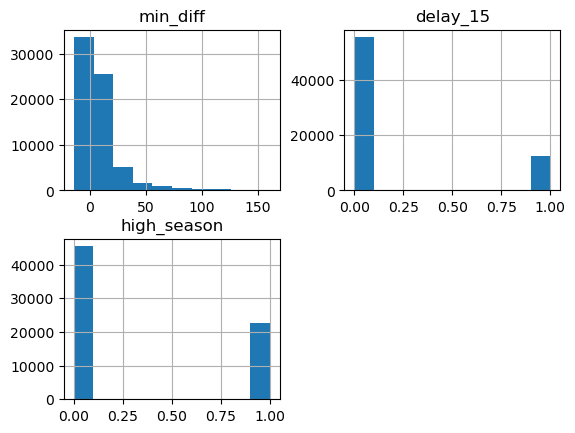

In [133]:
df_total[['min_diff',"delay_15","high_season"]].hist() 
plt.title("Histograma de min_diff y delay_15")
plt.show

<Axes: >

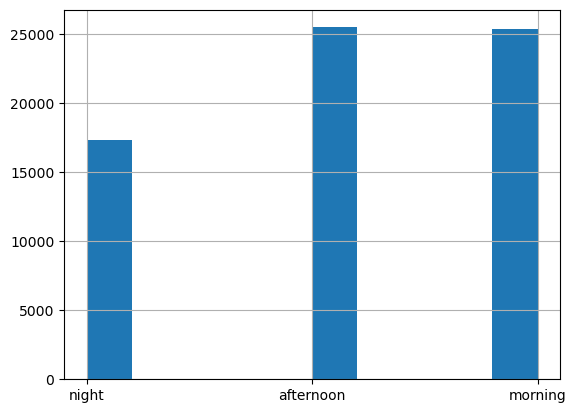

In [150]:
df_total["period_day"].hist() 

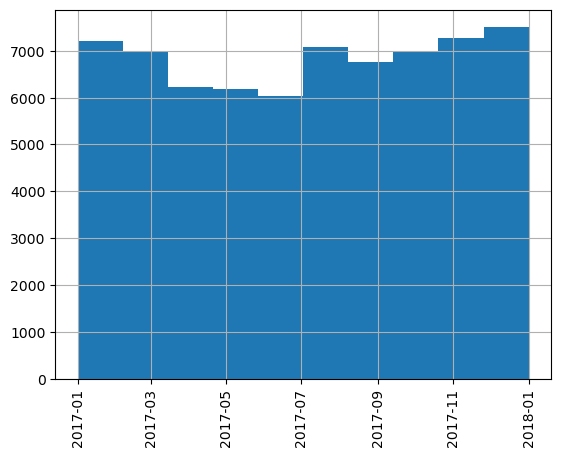

In [145]:
# plt.xticks(rotation=90)
for i in ["date_i"]:
    df_total[i].hist() 
    plt.xticks(rotation=90)
    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

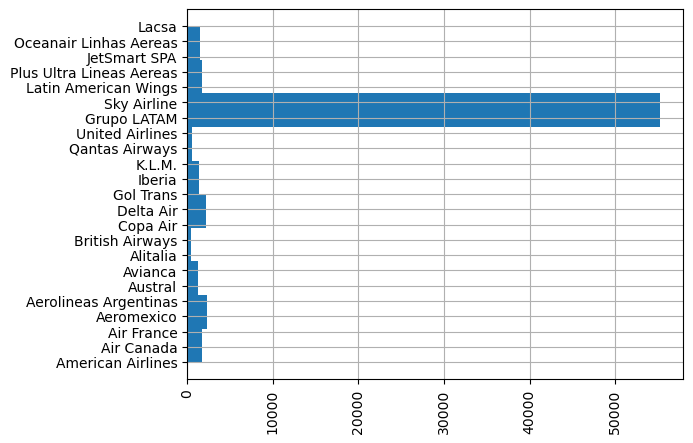

In [154]:
df_total["OPERA"].hist( orientation=u'horizontal') 
plt.xticks(rotation=90)
plt.show


In [37]:
df_total.describe(include="all").T

C:\Users\user\AppData\Local\Temp\ipykernel_8368\673917450.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_total.describe(include="all").T
C:\Users\user\AppData\Local\Temp\ipykernel_8368\673917450.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_total.describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id_vuelo,68206,68206,0,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fecha-I,68206,53252,2017-07-28 13:30:00,6,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vlo-I,68206,584,174,686,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ori-I,68206,1,SCEL,68206,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Des-I,68206,64,SCFA,5787,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Emp-I,68206,30,LAN,37611,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fecha-O,68206,62774,2017-11-05 14:51:00,5,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vlo-O,68205,861,174,649,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ori-O,68206,1,SCEL,68206,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Des-O,68206,63,SCFA,5786,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Ubicaciones posibles

**Ciudad de Origen**

Identificar valides de los códigos de destinos y cuales son realmente significativos, para representar la ubicacion. Se aprecia que todos los vuelos provienen de Santiago, la columna principal a utilizar es `SIGLAORI`


In [84]:
#==========================================
# Todos los registros probienen de Santiago
#==========================================
list_group=[
            "SIGLAORI", 
            "Ori-O",
            "Ori-I",
            "TIPOVUELO",
            ]

df_groupby_subtotal(df_total,list_group)

,SIGLAORI,Ori-O,Ori-I,TIPOVUELO,subtotal,total,porcentaje en %
0,Santiago,SCEL,SCEL,I,31240,68206,45.8
1,Santiago,SCEL,SCEL,N,36966,68206,54.2


In [ ]:
# Distribucion 
df_total[["SIGLAORI","TIPOVUELO"] + ["period_day", "min_diff", "delay_15"]
         ].groupby(["SIGLAORI","TIPOVUELO"]).describe()\
        .sort_values(by = ('min_diff', 'count') ,ascending= False).T

SIGLAORI            Santiago              
TIPOVUELO                  N             I
min_diff count  3.696600e+04  3.124000e+04
         mean            inf           inf
         std    1.706250e+01  2.159375e+01
         min   -1.400000e+01 -1.400000e+01
         25%   -1.000000e+00 -1.000000e+00
         50%    3.000000e+00  5.000000e+00
         75%    1.000000e+01  1.400000e+01
         max    1.610000e+02  1.610000e+02
delay_15 count  3.696600e+04  3.124000e+04
         mean   1.506348e-01  2.257080e-01
         std    3.579102e-01  4.182129e-01
         min    0.000000e+00  0.000000e+00
         25%    0.000000e+00  0.000000e+00
         50%    0.000000e+00  0.000000e+00
         75%    0.000000e+00  0.000000e+00
         max    1.000000e+00  1.000000e+00

### Ciudades de Destino
La columna `SIGLADES` es la que representa el resto de las colummnas, por lo cual esta es la que representa la ciudad de destino de forma más general.
Luego viene la columna `Des-O` que solo varia para la ciudad de `Buenos Aires` 
y por último la columna `Des-I` puede variar para una ciudad.

In [86]:
# Destintos más concurridos
# ==========================================
# Permite identificar qué columna 
# representa mejor el destino del vuelo
list_group=[
        "SIGLADES",
        "Des-O",
        "Des-I",]
print("Distribución cantidad de vuelos por ciudad de destino")
df_relacion_cod_label = df_groupby_subtotal(df_total,list_group)

# Describe la distribución
# df_relacion_cod_label.describe(include="all")
df_relacion_cod_label.head(20)

Distribución cantidad de vuelos por ciudad de destino


,SIGLADES,Des-O,Des-I,subtotal,total,porcentaje en %
0,Antofagasta,SCFA,SCFA,5786,5786,100.00
34,Lima,SPJC,SPJC,5270,5270,100.00
13,Calama,SCCF,SCCF,5145,5146,99.98
14,Calama,SCCF,SCFA,1,5146,0.02
53,Puerto Montt,SCTE,SCTE,4351,4357,99.86
52,Puerto Montt,SCTE,SCIE,1,4357,0.02
51,Puerto Montt,SCTE,SCCI,1,4357,0.02
50,Puerto Montt,SCTE,SCBA,4,4357,0.09
22,Concepcion,SCIE,SCIE,3993,3993,100.00
30,Iquique,SCDA,SCDA,3747,3747,100.00


In [109]:
# Distribucion Destintos más concurridos
df_total[["SIGLADES",
          "period_day", "min_diff", "delay_15"
          ]].groupby("SIGLADES").describe()\
        .sort_values(by = ('min_diff', 'count') ,ascending= False).head(20).T

SIGLADES        Buenos Aires  Antofagasta         Lima       Calama  \
min_diff count   6335.000000  5786.000000  5270.000000  5146.000000   
         mean            inf     7.027344    11.734375     5.972656   
         std       21.203125    16.500000    22.796875    15.250000   
         min      -14.000000   -13.000000   -14.000000   -14.000000   
         25%        0.000000    -1.000000     0.000000    -1.000000   
         50%        6.000000     2.000000     5.000000     2.000000   
         75%       16.000000     9.000000    14.000000     7.000000   
         max      161.000000   161.000000   161.000000   161.000000   
delay_15 count   6335.000000  5786.000000  5270.000000  5146.000000   
         mean       0.255615     0.146484     0.230225     0.122253   
         std        0.436035     0.353516     0.421143     0.327637   
         min        0.000000     0.000000     0.000000     0.000000   
         25%        0.000000     0.000000     0.000000     0.000000   
         50%        0.000000     0.000000     0.000000     0.000000   
         75%        1.000000     0.000000     0.000000     0.000000   
         max        1.000000     1.000000     1.000000     1.000000   

SIGLADES        Puerto Montt   Concepcion      Iquique    Sao Paulo  \
min_diff count   4357.000000  3993.000000  3747.000000  3569.000000   
         mean       8.898438     8.328125     8.625000    11.617188   
         std       16.671875    19.687500    16.953125    21.812500   
         min      -14.000000   -14.000000   -14.000000   -14.000000   
         25%        0.000000    -1.000000     0.000000     0.000000   
         50%        4.000000     3.000000     4.000000     6.000000   
         75%       11.000000    10.000000    11.000000    15.000000   
         max      161.000000   161.000000   157.000000   159.000000   
delay_15 count   4357.000000  3993.000000  3747.000000  3569.000000   
         mean       0.168457     0.156006     0.170776     0.246948   
         std        0.374268     0.362793     0.376221     0.431152   
         min        0.000000     0.000000     0.000000     0.000000   
         25%        0.000000     0.000000     0.000000     0.000000   
         50%        0.000000     0.000000     0.000000     0.000000   
         75%        0.000000     0.000000     0.000000     0.000000   
         max        1.000000     1.000000     1.000000     1.000000   

SIGLADES             Temuco        Arica    La Serena  Punta Arenas  \
min_diff count  2589.000000  2436.000000  2410.000000   2105.000000   
         mean      8.164062     7.144531     8.148438      9.101562   
         std      16.671875    16.562500    18.375000     15.921875   
         min     -10.000000   -13.000000   -13.000000    -14.000000   
         25%       0.000000    -1.000000    -1.000000      1.000000   
         50%       4.000000     3.000000     3.000000      5.000000   
         75%      10.000000     9.000000    10.000000     11.000000   
         max     158.000000   159.000000   155.000000    158.000000   
delay_15 count  2589.000000  2436.000000  2410.000000   2105.000000   
         mean      0.155762     0.135498     0.161865      0.154053   
         std       0.362549     0.342285     0.368164      0.361084   
         min       0.000000     0.000000     0.000000      0.000000   
         25%       0.000000     0.000000     0.000000      0.000000   
         50%       0.000000     0.000000     0.000000      0.000000   
         75%       0.000000     0.000000     0.000000      0.000000   
         max       1.000000     1.000000     1.000000      1.000000   

SIGLADES        Ciudad de Panama      Copiapo      Mendoza       Bogota  \
min_diff count       1850.000000  1780.000000  1625.000000  1604.000000   
         mean           0.214111     7.156250    15.515625    12.242188   
         std           11.617188    16.046875    27.265625    24.656250   
         min          -14.000000   -14.000000   -13.000000   -14.000000   
 

## Codificacion de los operadores

Los operadores, poseen una distinción entre los códigos, ya que el código representa que sub emperesa se hace carga del vuelo. Por ejemplo 
`Grupo LATAM` posee :
`LXP`,
`TAM`,
`LPE`,
`DSM`,
`LNE`,
`LAP`,


In [88]:
# ==========================================
# Destintos más concurridos
# ==========================================
# Permite identificar qué columna 
# representa mejor el destino del vuelo
list_group=[
            "OPERA",        # : "Name of the airline that operates"
            "Emp-O",        # : "Código de la línea aérea del vuelo operado"
            ]
df_relacion_cod_label =group_by_col (
    df_total, list_group,"id_vuelo").reset_index()
print("Distribución cantidad de vuelos por Aerolinea")
# Destino más concurridos y distribuciones de vuelos

df_relacion_cod_label.describe(include="all")

Distribución cantidad de vuelos por Aerolinea


,OPERA,Emp-O,count_reg
count,35,35,35.000000
unique,23,32,NaN
top,Grupo LATAM,ARG,NaN
freq,7,2,NaN
mean,NaN,NaN,1948.742857
std,NaN,NaN,4695.326295
min,NaN,NaN,2.000000
25%,NaN,NaN,200.000000
50%,NaN,NaN,358.000000
75%,NaN,NaN,990.000000


## Graficos

In [163]:
df_total[df_total.delay_15 != 0].groupby("mes_name").count()

,id_vuelo,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,...,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,date_i,date_o,high_season,period_day,min_diff,delay_15
mes_name,,,,,,,,,,,,,,,,,,,,,
Abril,585,585,585,585,585,585,585,585,585,585,...,585,585,585,585,585,585,585,585,585,585
Agosto,996,996,996,996,996,996,996,996,996,996,...,996,996,996,996,996,996,996,996,996,996
Diciembre,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615,...,1615,1615,1615,1615,1615,1615,1615,1615,1615,1615
Enero,978,978,978,978,978,978,978,978,978,978,...,978,978,978,978,978,978,978,978,978,978
Febrero,843,843,843,843,843,843,843,843,843,843,...,843,843,843,843,843,843,843,843,843,843
Julio,1758,1758,1758,1758,1758,1758,1758,1758,1758,1758,...,1758,1758,1758,1758,1758,1758,1758,1758,1758,1758
Junio,852,852,852,852,852,852,852,852,852,852,...,852,852,852,852,852,852,852,852,852,852
Marzo,631,631,631,631,631,631,631,631,631,631,...,631,631,631,631,631,631,631,631,631,631
Mayo,827,827,827,827,827,827,827,827,827,827,...,827,827,827,827,827,827,827,827,827,827


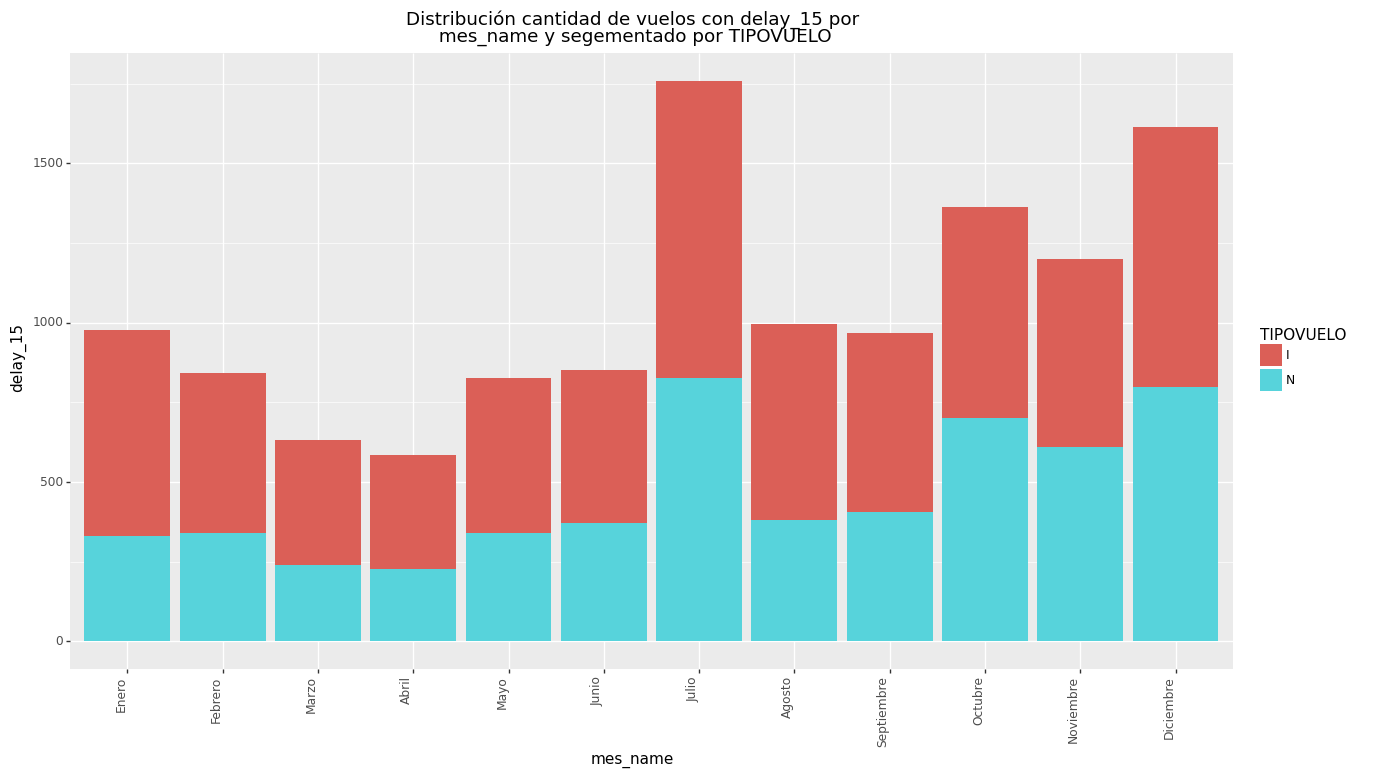

<ggplot: (95558225293)>

In [166]:
g_x_label="mes_name"
g_y_label="delay_15"
g_fill_label="TIPOVUELO"
g_title = (f"Distribución cantidad de vuelos con {g_y_label} por"
           f"\n {g_x_label} y segementado por {g_fill_label}")

graf_out =(ggplot(df_total, aes(x=g_x_label,
                                y=g_y_label,
                                fill=g_fill_label))
                + geom_col()
                +ggtitle(g_title)
                +theme(axis_text_x = element_text(angle=90, hjust=1),figure_size=(15,8))
            + scale_x_discrete(limits= exp_lib.array_mes_name)
                )
graf_out

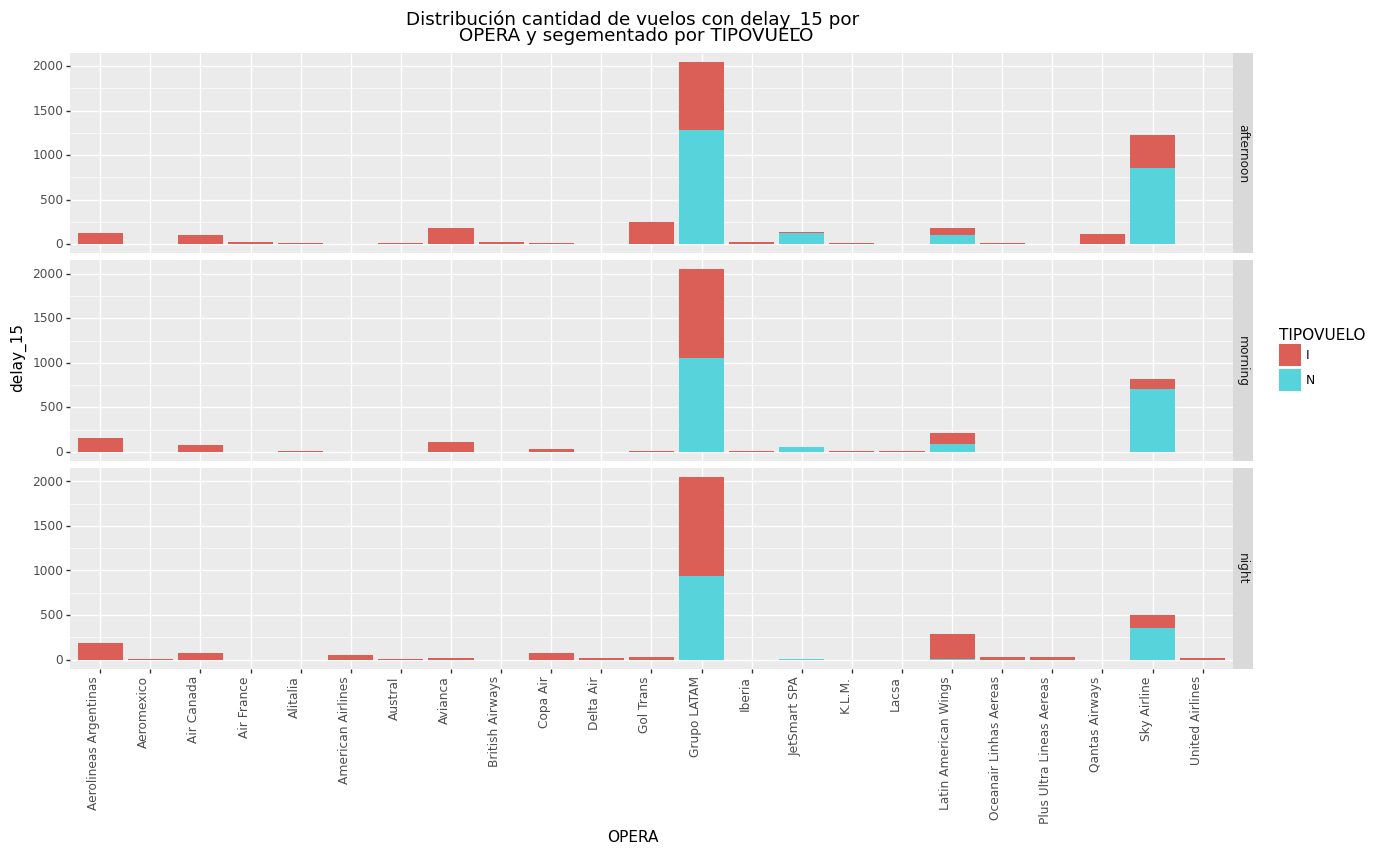

<ggplot: (95436362479)>

In [185]:

g_x_label="OPERA"
g_y_label="delay_15"
g_fill_label="TIPOVUELO"
left_grid = "period_day"
rigth_grid = "."
facet_str =str( f"{left_grid} ~ {rigth_grid}")

g_title = (f"Distribución cantidad de vuelos con {g_y_label} por"
           f"\n {g_x_label} y segementado por {g_fill_label}")

# g_plot =[]
# for i in df_g["OPERA"].unique().tolist():  
graf_out =(ggplot(df_total, aes(x=g_x_label, y=g_y_label, fill=g_fill_label))
                + geom_col()
                +ggtitle(g_title)
                +theme(axis_text_x = element_text(angle=90, hjust=1),figure_size=(15,8))
                +facet_grid(facet_str)
                )
graf_out

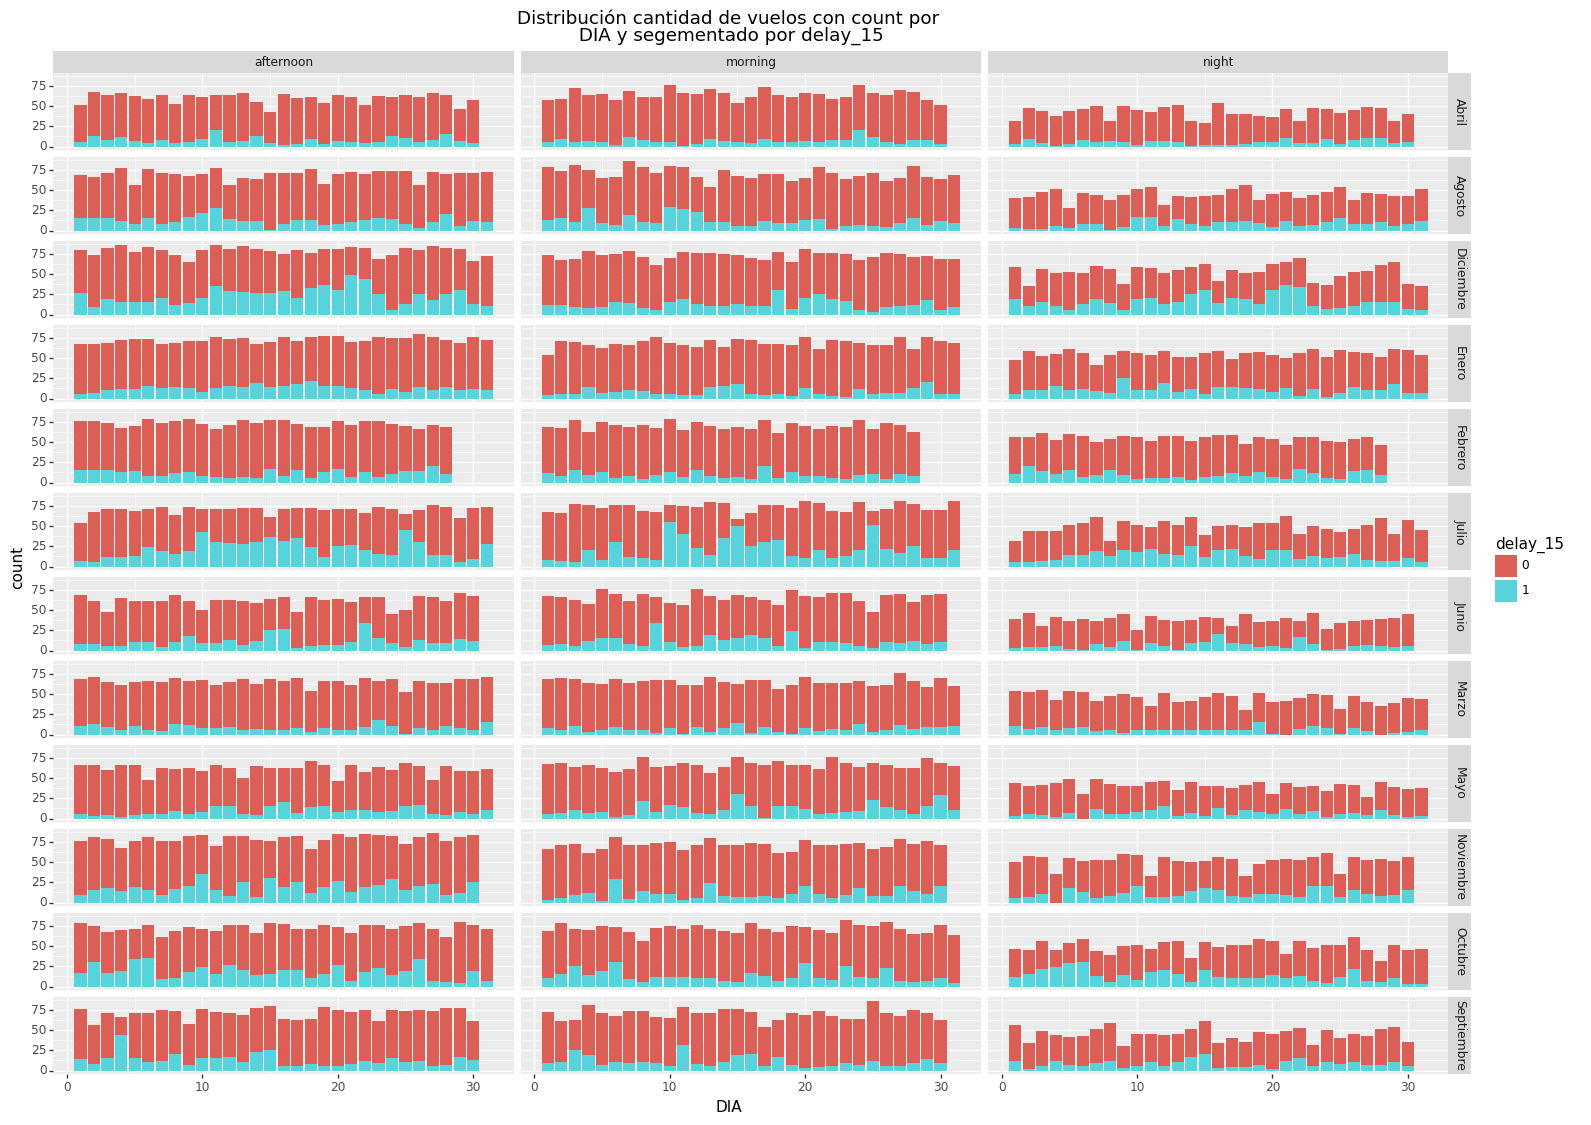

<ggplot: (95431597354)>

In [204]:
g_x_label="DIA"
# g_y_label="delay_15" "count"
g_y_label= "count"

g_fill_label="delay_15"
left_grid = "mes_name"
rigth_grid = "period_day"
facet_str =str( f"{left_grid} ~ {rigth_grid}")

g_title = (f"Distribución cantidad de vuelos con {g_y_label} por"
           f"\n {g_x_label} y segementado por {g_fill_label}")

# g_plot =[]
# for i in df_g["OPERA"].unique().tolist():  
df_graf = df_total.copy()
df_graf["delay_15"] = df_graf["delay_15"].astype("category")
df_graf["count"] = 1
graf_out =(ggplot(df_graf, aes(x=g_x_label, y=g_y_label, fill=g_fill_label))
                + geom_col()
                +ggtitle(g_title)
                +theme( # axis_text_x = element_text(angle=90, hjust=1),
                       figure_size=(18,13))
                +facet_grid(facet_str)
                )
graf_out